# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import glob
import os

from timeit import default_timer as timer

# Preparation Data set

In [2]:
Transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5)])

train_dataset = torchvision.datasets.MNIST(root = "data", train = True, download = True, transform = Transforms)

test_dataset = torchvision.datasets.MNIST(root = "data",train = False, download = True,transform = Transforms)

train_dataloader = DataLoader(dataset = train_dataset,batch_size = 128,num_workers = 2,shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 128,num_workers = 2)

100%|██████████| 9912422/9912422 [00:00<00:00, 96956472.93it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91769465.02it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25369456.38it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17541923.36it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Creat SCNNB Model

In [3]:
class SCNNB_Model(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        
        self.CNN_block = nn.Sequential(
            nn.Conv2d(input_shape,  32, kernel_size = (3,3), stride = 1, padding = 1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(32, 64, kernel_size = (3,3), stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64*7*7, out_features = output_shape),
            nn.Dropout(0.5),
            nn.Softmax(1)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.CNN_block(x)
        x = self.classifier(x)
        return x


In [4]:
model1 = SCNNB_Model(input_shape=1,  output_shape=10)
model1

SCNNB_Model(
  (CNN_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Softmax(dim=1)
  )
)

# Train SCNNB Model

In [5]:
def train_step(model,data_loader,loss_fn, optimizer, accuracy_fn,device):
    
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(), pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        
    return train_loss.item(), train_acc


In [6]:
def test_step(model, data_loader,loss_fn,accuracy_fn, device):
    
    model.to(device)
    model.eval() 
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(true=y.cpu(),pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(train_acc=test_acc/counter, train_loss=test_loss.item()/counter, refresh=True)

        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)
            
    return test_loss.item(), test_acc

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr = 0.02, momentum=0.9, weight_decay=0.000005)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [8]:

from timeit import default_timer as timer
train_epoch_loss_model1 = []
train_epoch_accuracy_model1 = []
test_epoch_loss_model1 = []
test_epoch_accuracy_model1 = []

train_time_start = timer()

epochs = 150
for epoch in range(epochs):
    print("EPOCH {}/{} :".format(epoch +1, epochs))
    train_loss, train_acc = train_step(data_loader=train_dataloader,
                                              model=model1, 
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              accuracy_fn=accuracy_fn,
                                              device=device
                                              )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
                                     model=model1,
                                     loss_fn=loss_fn,
                                     accuracy_fn=accuracy_fn,
                                      device=device
                                      )
    
    train_epoch_loss_model1.append(train_loss)
    train_epoch_accuracy_model1.append(train_acc)
    test_epoch_loss_model1.append(test_loss)
    test_epoch_accuracy_model1.append(test_acc)

train_time_end = timer()
total_time = train_time_end - train_time_start
print(f"\n\nTrain time: {total_time:.3f} seconds")

EPOCH 1/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.81it/s, train_acc=96.7, train_loss=1.5]


EPOCH 2/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.78it/s, train_acc=97.9, train_loss=1.48]


EPOCH 3/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.59it/s, train_acc=98.6, train_loss=1.48]


EPOCH 4/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.53it/s, train_acc=98.4, train_loss=1.48]


EPOCH 5/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.63it/s, train_acc=98.8, train_loss=1.47]


EPOCH 6/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.55it/s, train_acc=98.5, train_loss=1.48]


EPOCH 7/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.67it/s, train_acc=98.8, train_loss=1.47]


EPOCH 8/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.88it/s, train_acc=98.9, train_loss=1.47]


EPOCH 9/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.72it/s, train_acc=99, train_loss=1.47]


EPOCH 10/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.66it/s, train_acc=99, train_loss=1.47]


EPOCH 11/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.45it/s, train_acc=99, train_loss=1.47]


EPOCH 12/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.76it/s, train_acc=99, train_loss=1.47]


EPOCH 13/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.82it/s, train_acc=99.1, train_loss=1.47]


EPOCH 14/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.29it/s, train_acc=99, train_loss=1.47]


EPOCH 15/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.65it/s, train_acc=99, train_loss=1.47]


EPOCH 16/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.34it/s, train_acc=99, train_loss=1.47]


EPOCH 17/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.28it/s, train_acc=99, train_loss=1.47]


EPOCH 18/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.60it/s, train_acc=99.1, train_loss=1.47]


EPOCH 19/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.04it/s, train_acc=99.1, train_loss=1.47]


EPOCH 20/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.83it/s, train_acc=99.1, train_loss=1.47]


EPOCH 21/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s, train_acc=98.9, train_loss=1.47]


EPOCH 22/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.08it/s, train_acc=99, train_loss=1.47]


EPOCH 23/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.53it/s, train_acc=99, train_loss=1.47]


EPOCH 24/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.89it/s, train_acc=99, train_loss=1.47]


EPOCH 25/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.19it/s, train_acc=99.1, train_loss=1.47]


EPOCH 26/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.26it/s, train_acc=99.1, train_loss=1.47]


EPOCH 27/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.57it/s, train_acc=99.1, train_loss=1.47]


EPOCH 28/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.21it/s, train_acc=99.1, train_loss=1.47]


EPOCH 29/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.73it/s, train_acc=99.1, train_loss=1.47]


EPOCH 30/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.39it/s, train_acc=99.1, train_loss=1.47]


EPOCH 31/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 33.16it/s, train_acc=99.1, train_loss=1.47]


EPOCH 32/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.16it/s, train_acc=99.1, train_loss=1.47]


EPOCH 33/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.41it/s, train_acc=99.1, train_loss=1.47]


EPOCH 34/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.46it/s, train_acc=99.1, train_loss=1.47]


EPOCH 35/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.90it/s, train_acc=99.1, train_loss=1.47]


EPOCH 36/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.56it/s, train_acc=99.1, train_loss=1.47]


EPOCH 37/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.67it/s, train_acc=99.1, train_loss=1.47]


EPOCH 38/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.94it/s, train_acc=99, train_loss=1.47]


EPOCH 39/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.12it/s, train_acc=99.1, train_loss=1.47]


EPOCH 40/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.13it/s, train_acc=99.1, train_loss=1.47]


EPOCH 41/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s, train_acc=99.1, train_loss=1.47]


EPOCH 42/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.82it/s, train_acc=99, train_loss=1.47]


EPOCH 43/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.89it/s, train_acc=99.1, train_loss=1.47]


EPOCH 44/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.10it/s, train_acc=99, train_loss=1.47]


EPOCH 45/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.88it/s, train_acc=99.1, train_loss=1.47]


EPOCH 46/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.54it/s, train_acc=99.1, train_loss=1.47]


EPOCH 47/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.43it/s, train_acc=99.1, train_loss=1.47]


EPOCH 48/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s, train_acc=99.1, train_loss=1.47]


EPOCH 49/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.02it/s, train_acc=99.1, train_loss=1.47]


EPOCH 50/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.99it/s, train_acc=99, train_loss=1.47]


EPOCH 51/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.87it/s, train_acc=99, train_loss=1.47]


EPOCH 52/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.53it/s, train_acc=99, train_loss=1.47]


EPOCH 53/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.75it/s, train_acc=99.1, train_loss=1.47]


EPOCH 54/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.58it/s, train_acc=99.1, train_loss=1.47]


EPOCH 55/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.28it/s, train_acc=99.1, train_loss=1.47]


EPOCH 56/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.42it/s, train_acc=99.1, train_loss=1.47]


EPOCH 57/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.45it/s, train_acc=99.1, train_loss=1.47]


EPOCH 58/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.83it/s, train_acc=99.1, train_loss=1.47]


EPOCH 59/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.30it/s, train_acc=99.1, train_loss=1.47]


EPOCH 60/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.86it/s, train_acc=99.1, train_loss=1.47]


EPOCH 61/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.31it/s, train_acc=99.1, train_loss=1.47]


EPOCH 62/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 26.75it/s, train_acc=99.1, train_loss=1.47]


EPOCH 63/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.06it/s, train_acc=99.1, train_loss=1.47]


EPOCH 64/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.95it/s, train_acc=99.1, train_loss=1.47]


EPOCH 65/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.45it/s, train_acc=99.1, train_loss=1.47]


EPOCH 66/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.30it/s, train_acc=99.1, train_loss=1.47]


EPOCH 67/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.09it/s, train_acc=99.1, train_loss=1.47]


EPOCH 68/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 32.13it/s, train_acc=99.1, train_loss=1.47]


EPOCH 69/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.38it/s, train_acc=99.1, train_loss=1.47]


EPOCH 70/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.25it/s, train_acc=99.1, train_loss=1.47]


EPOCH 71/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.22it/s, train_acc=99.1, train_loss=1.47]


EPOCH 72/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s, train_acc=99.1, train_loss=1.47]


EPOCH 73/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.41it/s, train_acc=99.1, train_loss=1.47]


EPOCH 74/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.55it/s, train_acc=99.1, train_loss=1.47]


EPOCH 75/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.14it/s, train_acc=99.1, train_loss=1.47]


EPOCH 76/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.30it/s, train_acc=99.1, train_loss=1.47]


EPOCH 77/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.82it/s, train_acc=99.1, train_loss=1.47]


EPOCH 78/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.20it/s, train_acc=99.1, train_loss=1.47]


EPOCH 79/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.55it/s, train_acc=99.1, train_loss=1.47]


EPOCH 80/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 26.34it/s, train_acc=99.1, train_loss=1.47]


EPOCH 81/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.20it/s, train_acc=99.1, train_loss=1.47]


EPOCH 82/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.71it/s, train_acc=99.1, train_loss=1.47]


EPOCH 83/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.46it/s, train_acc=99, train_loss=1.47]


EPOCH 84/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.07it/s, train_acc=99.1, train_loss=1.47]


EPOCH 85/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.42it/s, train_acc=99.1, train_loss=1.47]


EPOCH 86/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 26.44it/s, train_acc=99.1, train_loss=1.47]


EPOCH 87/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.09it/s, train_acc=99.1, train_loss=1.47]


EPOCH 88/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.53it/s, train_acc=99, train_loss=1.47]


EPOCH 89/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.43it/s, train_acc=99.1, train_loss=1.47]


EPOCH 90/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.78it/s, train_acc=99.1, train_loss=1.47]


EPOCH 91/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.14it/s, train_acc=99.1, train_loss=1.47]


EPOCH 92/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.92it/s, train_acc=99, train_loss=1.47]


EPOCH 93/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.03it/s, train_acc=99.1, train_loss=1.47]


EPOCH 94/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.58it/s, train_acc=99.1, train_loss=1.47]


EPOCH 95/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.67it/s, train_acc=99.1, train_loss=1.47]


EPOCH 96/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.50it/s, train_acc=99.1, train_loss=1.47]


EPOCH 97/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.36it/s, train_acc=99.1, train_loss=1.47]


EPOCH 98/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.72it/s, train_acc=99.1, train_loss=1.47]


EPOCH 99/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 25.30it/s, train_acc=99.1, train_loss=1.47]


EPOCH 100/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.12it/s, train_acc=99.1, train_loss=1.47]


EPOCH 101/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.12it/s, train_acc=99.1, train_loss=1.47]


EPOCH 102/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.84it/s, train_acc=99.1, train_loss=1.47]


EPOCH 103/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.42it/s, train_acc=99.1, train_loss=1.47]


EPOCH 104/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.16it/s, train_acc=99.1, train_loss=1.47]


EPOCH 105/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.22it/s, train_acc=99.1, train_loss=1.47]


EPOCH 106/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.66it/s, train_acc=99.1, train_loss=1.47]


EPOCH 107/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.38it/s, train_acc=99.1, train_loss=1.47]


EPOCH 108/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.87it/s, train_acc=99.1, train_loss=1.47]


EPOCH 109/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.43it/s, train_acc=99.1, train_loss=1.47]


EPOCH 110/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.06it/s, train_acc=99.1, train_loss=1.47]


EPOCH 111/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.11it/s, train_acc=99.1, train_loss=1.47]


EPOCH 112/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.25it/s, train_acc=99.1, train_loss=1.47]


EPOCH 113/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.29it/s, train_acc=99.1, train_loss=1.47]


EPOCH 114/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.84it/s, train_acc=99.1, train_loss=1.47]


EPOCH 115/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.31it/s, train_acc=99.1, train_loss=1.47]


EPOCH 116/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.35it/s, train_acc=99.1, train_loss=1.47]


EPOCH 117/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.90it/s, train_acc=99.1, train_loss=1.47]


EPOCH 118/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.57it/s, train_acc=99.1, train_loss=1.47]


EPOCH 119/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.12it/s, train_acc=99.1, train_loss=1.47]


EPOCH 120/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.56it/s, train_acc=99.1, train_loss=1.47]


EPOCH 121/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.14it/s, train_acc=99.1, train_loss=1.47]


EPOCH 122/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 28.43it/s, train_acc=99.1, train_loss=1.47]


EPOCH 123/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.99it/s, train_acc=99.1, train_loss=1.47]


EPOCH 124/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.00it/s, train_acc=99.1, train_loss=1.47]


EPOCH 125/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.61it/s, train_acc=99.1, train_loss=1.47]


EPOCH 126/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.60it/s, train_acc=99.1, train_loss=1.47]


EPOCH 127/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.32it/s, train_acc=99.1, train_loss=1.47]


EPOCH 128/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.61it/s, train_acc=99.1, train_loss=1.47]


EPOCH 129/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.87it/s, train_acc=99.1, train_loss=1.47]


EPOCH 130/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 22.77it/s, train_acc=99.1, train_loss=1.47]


EPOCH 131/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.11it/s, train_acc=99.1, train_loss=1.47]


EPOCH 132/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.32it/s, train_acc=99.1, train_loss=1.47]


EPOCH 133/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.30it/s, train_acc=99.1, train_loss=1.47]


EPOCH 134/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.54it/s, train_acc=99.1, train_loss=1.47]


EPOCH 135/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.62it/s, train_acc=99.1, train_loss=1.47]


EPOCH 136/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 24.95it/s, train_acc=99.1, train_loss=1.47]


EPOCH 137/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.84it/s, train_acc=99.1, train_loss=1.47]


EPOCH 138/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.21it/s, train_acc=99.1, train_loss=1.47]


EPOCH 139/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 31.23it/s, train_acc=99.1, train_loss=1.47]


EPOCH 140/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s, train_acc=99.1, train_loss=1.47]


EPOCH 141/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.46it/s, train_acc=99.1, train_loss=1.47]


EPOCH 142/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.66it/s, train_acc=99.1, train_loss=1.47]


EPOCH 143/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.60it/s, train_acc=99.1, train_loss=1.47]


EPOCH 144/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.90it/s, train_acc=99.1, train_loss=1.47]


EPOCH 145/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 27.10it/s, train_acc=99.1, train_loss=1.47]


EPOCH 146/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.49it/s, train_acc=99.1, train_loss=1.47]


EPOCH 147/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 23.51it/s, train_acc=99.1, train_loss=1.47]


EPOCH 148/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 29.95it/s, train_acc=99, train_loss=1.47]


EPOCH 149/150 :


   test: 100%|██████████| 79/79 [00:03<00:00, 21.26it/s, train_acc=99.1, train_loss=1.47]


EPOCH 150/150 :


   test: 100%|██████████| 79/79 [00:02<00:00, 30.56it/s, train_acc=99.1, train_loss=1.47]




Train time: 2886.529 seconds


In [9]:
torch.save(model1.state_dict(), 'saved_model')

# Plot and Evaluation

In [11]:
y_preds = []
model1.eval()
for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model1(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())
    
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 79/79 [00:02<00:00, 30.64it/s]


In [12]:
from sklearn.metrics import accuracy_score
print("model 1 accuracy=",accuracy_score(test_dataset.targets,y_pred_tensor,normalize = True))

model 1 accuracy= 0.9905


In [13]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_true=test_dataset.targets,
                      y_pred=y_pred_tensor)
CM

array([[ 977,    0,    1,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1130,    1,    2,    0,    0,    1,    0,    1,    0],
       [   1,    2, 1024,    0,    1,    0,    0,    4,    0,    0],
       [   0,    0,    1, 1003,    0,    4,    0,    1,    1,    0],
       [   0,    0,    0,    0,  978,    0,    1,    1,    1,    1],
       [   2,    0,    0,    8,    0,  881,    1,    0,    0,    0],
       [   4,    2,    0,    1,    2,    3,  943,    0,    3,    0],
       [   0,    4,    5,    1,    0,    0,    0, 1015,    1,    2],
       [   3,    0,    3,    0,    1,    1,    0,    2,  962,    2],
       [   2,    0,    1,    1,    6,    3,    0,    4,    0,  992]])

In [16]:
def accloss_plots(train_loss=train_epoch_loss_model1, 
                  test_loss=test_epoch_loss_model1, 
                  train_acc=train_epoch_accuracy_model1, 
                  test_acc=test_epoch_accuracy_model1):
  
    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.show();

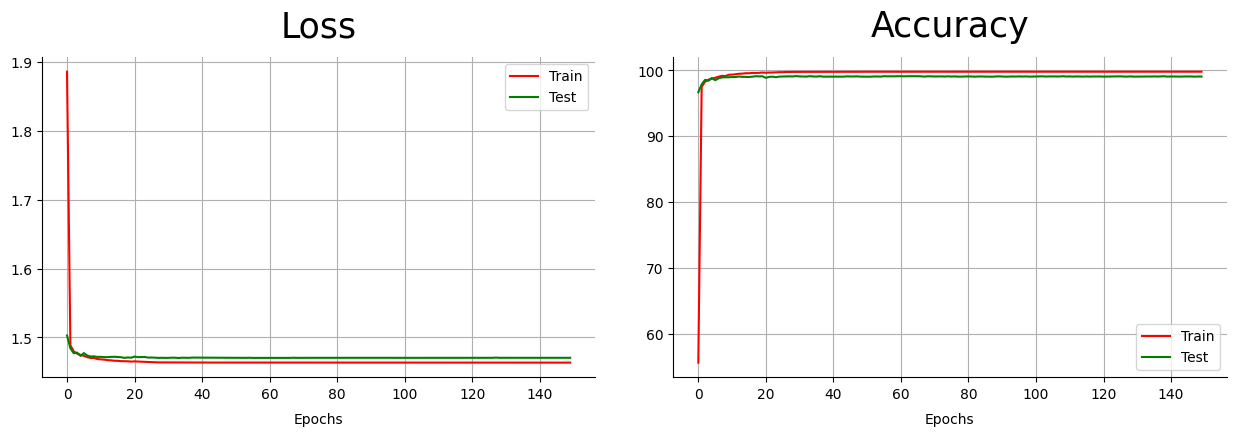

In [17]:
accloss_plots()